# Classification de documents

Utilisation des réseaux de convolution(CNN) et de la représentation de mots (Word Embedding) pour faire la classification de documents

### Chargement et pré-traitement du corpus

In [0]:
import io
from os import path
import string
import numpy as np
import re

if not path.exists("TRAIN_FILE.TXT"):
    !wget http://mediamining.univ-lyon2.fr/people/guille/word_embedding/TRAIN_FILE.TXT
if not path.exists("TEST_FILE_FULL.TXT"):
    !wget http://mediamining.univ-lyon2.fr/people/guille/word_embedding/TEST_FILE_FULL.TXT

merger = [re.compile("(<e1>).*(<\/e1>)"), re.compile("(<e2>).*(<\/e2>)")]


def extract_entity(sentence, k):
    e_str = merger[k-1].search(sentence).group()
    sentence = sentence.replace(e_str, e_str.replace(" ", "_"))
    tokens = sentence.split(" ")
    tokens_clean = []
    index = 0
    for i in range(len(tokens)):
        token = tokens[i]
        if "<e"+str(k)+">" in token:
            index = i
            token = token.replace("<e"+str(k)+">", "").replace("</e"+str(k)+">", "").replace("_", " ")
        tokens_clean.append(token)
    return index, tokens_clean


def parse(text, update_vocabulary):
    lines = text.lower().split("\n")
    sentence = lines[0].split("\t")[1].strip('"')
    index_1, tokens_clean = extract_entity(sentence, 1)
    index_2, tokens_clean = extract_entity(" ".join(tokens_clean), 2)
    label = lines[1]
    tokens_clean = [token.strip(string.punctuation).replace("'s", "") for token in tokens_clean]
    if update_vocabulary:
        for token in tokens_clean:
            vocabulary.add(token)
    return tokens_clean, (index_1, index_2), label


def process_file(fname, update_vocabulary):
    sentences = []
    indexes = []
    labels = []
    with io.open(fname, "r", encoding="utf-8", newline="\n", errors="ignore") as input_file:
        text = ""
        for s in input_file:
            text += s
        blocks = text.split("\n\n")
        for block in blocks:
            parsed = parse(block, update_vocabulary)
            sentences.append(parsed[0])
            indexes.append(parsed[1])
            labels.append(parsed[2])
    return sentences, indexes, labels


vocabulary = set()
train_data = process_file("TRAIN_FILE.TXT", update_vocabulary=True)
test_data = process_file("TEST_FILE_FULL.TXT", update_vocabulary=False)

### Chargement des représentations des mots

In [0]:
import numpy as np


def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.array([float(tokens[i]) for i in range(1, 301)])
    return data

In [0]:
if not path.exists("wiki-news-300d-1M.vec"):
    !wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
    !unzip wiki-news-300d-1M.vec.zip

vectors = load_vectors("wiki-news-300d-1M.vec")

len(vocabulary),len(vectors)


(18186, 999994)

In [0]:
unknown_words = set([word for word in vocabulary if word not in vectors])
vocabulary = list(vocabulary - unknown_words)
word_map = {}
word_vectors = np.zeros((len(vocabulary) + 2, 300))
for i in range(len(vocabulary)):
    word_map[vocabulary[i]] = i
    word_vectors[i] = vectors[vocabulary[i]]
word_vectors[len(vocabulary)] = np.random.uniform(low=-0.1, high=0.1, size=300)
word_vectors[len(vocabulary) + 1] = np.random.uniform(low=-0.1, high=0.1, size=300)
default_index = len(vocabulary)
def get_index(word):
    return word_map.get(word, default_index)

### Préparation du corpus

In [0]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder

def format_sentences(sentences, indexes, max_length=None):
    if max_length == None:
        max_length = max([len(sentence) for sentence in sentences])
    sentences = [[get_index(t) for t in sentence] for sentence in sentences]
    sequences = pad_sequences(sentences, 
                              maxlen=max_length, 
                              dtype='int32', 
                              padding='post', 
                              truncating='pre',
                              value=len(vocabulary)+1) # id pour les tokens "hors phrase"

    positions_1 = []
    positions_2 = []
    for i in range(len(sentences)):
        index_1 = indexes[i][0]
        positions_1.append([max_length + j - index_1 - 1 for j in range(max_length)])
        index_2 = indexes[i][1]
        positions_2.append([max_length + j - index_2 - 1 for j in range(max_length)])
    positions_1 = np.array(positions_1, dtype=np.int32)
    positions_2 = np.array(positions_2, dtype=np.int32)

    return max_length, [sequences, positions_1, positions_2]

max_length, train_input = format_sentences(train_data[0], train_data[1])
_, test_input = format_sentences(test_data[0], test_data[1], max_length)

label_encoder = OneHotEncoder()
train_classes = label_encoder.fit_transform(np.array(train_data[2]).reshape(-1, 1))
test_classes = label_encoder.transform(np.array(test_data[2]).reshape(-1, 1))

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

### Définition du réseau de neurones

In [0]:
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, concatenate, Dense, Activation, Dropout
from keras.constraints import max_norm
from keras.initializers import glorot_normal
from keras.utils import plot_model


def initialize_model(W, P, max_length, n_filters=150, filter_sizes=[2, 3, 4, 5], activation="tanh", p=0.5, clip=3., train_word_vectors=True):
    # Configuration de l'entée
    input_words = Input(shape=(max_length, ), name="words")

    # Configuration de la couche de représentation des mots - statique
    word_embedding = Embedding(input_dim=len(vocabulary) + 2,
                               output_dim=300,
                               input_length=max_length,
                               weights=[W],
                               trainable=train_word_vectors,
                               name="word_embedding")(input_words)

    # Configuration des couches de représentation des positions - non-statiques
    

    # Concaténation des représentations des mots et des représentations des positions
    

    # Configuration des couches de convolution en parallèle, avec max pooling 
    convolution = Conv1D(n_filters,
                         kernel_size=2,
                         activation=activation,
                         name="convolution")(word_embedding)
        
    # Concaténation des sorties des couches de max pooling parallèles, avec dropout
    pooling = GlobalMaxPooling1D(name="pooling")(convolution)
    
    # Configuration de la couche de classification
    classification = Dense(19,
                           activation="softmax",
                           kernel_initializer=glorot_normal(),
                           name="classification")(pooling)
    
    return Model(inputs=[input_words], 
                 outputs=classification)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 8000 samples, validate on 2717 samples
Epoch 1/5
8000/8000 [==============================] - 5s 597us/step - loss: 2.4553 - accuracy: 0.2508 - val_loss: 2.0894 - val_accuracy: 0.3346
Epoch 2/5
8000/8000 [==============================] - 4s 532us/step - loss: 1.8484 - accuracy: 0.4345 - val_loss: 1.6557 - val_accuracy: 0.4921
Epoch 3/5
8000/8000 [==============================] - 4s 555us/step - loss: 1.4899 - accuracy: 0.5506 - val_loss: 1.4180 - val_accuracy: 0.5650
Epoch 4/5
8000/8000 [==============================] - 5s 563us/step - loss: 1.2305 - accuracy: 0.6310 - val_loss: 1.2818 - val_accuracy: 0.5922
Epoch 5/5
8000/8000 [==============================] - 4s 552us/step - loss: 1.0374 - accuracy: 0.6927 - val_loss: 1.1855 - val_accuracy: 0.6356


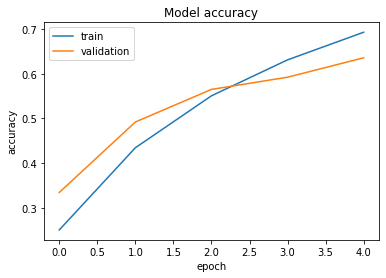

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# Initialisation du modèle
model = initialize_model(word_vectors,
                         None,
                         max_length, 
                         n_filters=150)
plot_model(model)

# Définition de l'objectif à minimiser
model.compile(loss="categorical_crossentropy",
              optimizer="adadelta",
              metrics=['accuracy'])

# Optimisation
log = model.fit(train_input[0],
                train_classes,
                batch_size=100,
                epochs=5,
                validation_data=(test_input[0],
                                 test_classes))

# Visualisation des courbes d'apprentissage
plt.plot(log.history['accuracy'])
plt.plot(log.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()